# 步骤1-1 模块导入

In [13]:
print("模块导入")
# !pip install opencv-python # 安装opencv模块，方便读取图片
import cv2 # 导入opencv操作模块
import os # 导入系统文件操作模块
import time # 导入时间操作模块
import copy # 导入复制操作的模块
import torch # 导入深度学习pytorch模块
import numpy as np # 导入numpy模块，进行数组操作
import torch.nn as nn # 从torch中导入网络模块
import torch.optim as optim # 从torch中导入优化器模块
import torch.nn.functional as F # 从torch中导入函数模块
from torch.autograd import Variable # 从torch中导入变量模块
import torch.backends.cudnn as cudnn # 从torch中导入cudnn模块
from nets.yolo4 import YoloBody,froze_params # 从自定义的nets.py中导入yolo网络和冻结参数名
from nets.yolo_training import YOLOLoss, Generator # 从自定义的nets.py中导入yolo损失函数和数据生成器函数
from matplotlib import pyplot as plt # 导入绘图模块
from yolo import YOLO # 导入yolo预测模型网络
from PIL import Image # 导入图片处理模块
from main import * # 从自定义的main.py中导入所有函数
print("模块导入完成！")

模块导入
模块导入完成！


# 步骤2-1 参数设定

In [3]:
print("参数设定")
input_shape = (416,416) # 输入的shape大小 显存比较小可以使用416x416；显存比较大可以使用608x608
# input_shape = (608, 608)
Cosine_lr = True # 确定是否使用基于余弦退火方法的学习率学习率调整策略
Cuda = False # 用于设定是否使用cuda
train_annotation_path = 'model_data/mask_train_new.txt' # 训练集记录文件路径
val_annotation_path = 'model_data/mask_val_new.txt' # 测试集记录文件路径
anchors_path = 'model_data/yolo_anchors.txt' # 先验框文件路径
classes_path = 'model_data/mask_classes_new.txt' # 先验类文件路径  
class_names = get_classes(classes_path) # 获取类别名称
anchors = get_anchors(anchors_path) # 获取先验框
num_classes = len(class_names) # 获取类别数量
lr = 1e-3 # 定义学习率
Batch_size = 1 # 定义批次大小
Init_Epoch = 0 # 定义开始epoch
Freeze_Epoch = 1 # 定义结束的epoch
iteration_step = 2 # 自定义一个epoch中的迭代数
print("参数设定完成！")

参数设定
参数设定完成！


# 步骤3-1 构建数据生成器

构建数据生成器
训练集大小：1148,验证集大小：132
展示部分部分数据
数据生成器构建完成


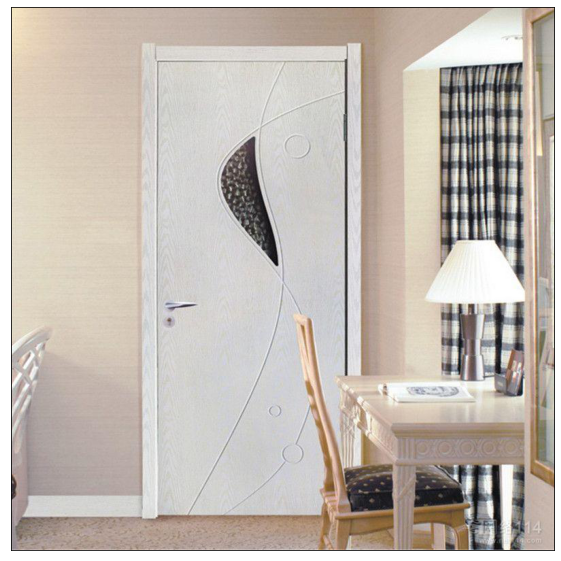

In [6]:
print("构建数据生成器")
with open(train_annotation_path) as f: # 读取训练数据文件
    train_lines = f.readlines()
with open(val_annotation_path) as f: # 读取验证数据文件
    val_lines = f.readlines()
num_train = len(train_lines) # 计算训练集大小
num_val = len(val_lines) # 计算验证集大小
print(f"训练集大小：{num_train},验证集大小：{num_val}")
epoch_size = min(int(max(1, num_train//Batch_size//2.5)),iteration_step) # 计算一个训练epoch的迭代次数  
epoch_size_val = min(num_val//Batch_size, iteration_step) # 计算一个测试epoch的迭代次数
gen = Generator(Batch_size, train_lines, (input_shape[0], input_shape[1])).generate(mosaic = True) # 构建训练数据生成器
gen_val = Generator(Batch_size, val_lines, (input_shape[0], input_shape[1])).generate(mosaic = False) # 构建验证数据生成器
print("展示部分部分数据")
# 调用show_image函数显示图片
show_image('train/image/door_029.jpg') 
# show_image('train/image/knife_023.jpg') 
# show_image('train/image/phone_027.jpg')
# show_image('train/image/scissor_030.jpg')
print("数据生成器构建完成")

# 步骤3-2 构建模型及损失函数

In [7]:
print("构建模型和损失函数")
model = YoloBody(len(anchors[0]), num_classes) # 创建模型
if Cuda: # 根据是否使用cuda部署模型
    cudnn.benchmark = True # 部署cuda后端
    net = net.cuda() # 将模型转到cuda上
else:
    net = model # 不对模型进行处理
print(net) # 打印模型结构
n_parameters = sum(p.numel() for p in net.parameters() if p.requires_grad) # 获取并打印模型参数数量
print('参数量:', n_parameters)
yolo_losses = [] # 建立记录loss函数的列表
for i in range(3):
    # 构建用于保存三种loss的numpy数组
    yolo_losses.append(YOLOLoss(np.reshape(anchors, [-1,2]), num_classes, (input_shape[1], input_shape[0]), 0.03, Cuda)) 
print("模型和损失函数构建完成！")

构建模型和损失函数
YoloBody(
  (backbone): CSPDarkNet(
    (conv1): BasicConv(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): Mish()
    )
    (stages): ModuleList(
      (0): Resblock_body(
        (downsample_conv): BasicConv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): Mish()
        )
        (split_conv0): BasicConv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): Mish()
        )
        (split_conv1): BasicConv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2

# 步骤3-3 构建优化器和学习率调整策略

In [8]:
print("构建优化器和学习率调整策略")
optimizer = optim.Adam(net.parameters(), lr, weight_decay=5e-4) # 定义优化器
if Cosine_lr: 
    lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-5) # 构建基于余弦退火方法的学习率调整策略
else:
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9) # 构建StepLR策略
print("构建优化器和学习率调整策略完成")

构建优化器和学习率调整策略
构建优化器和学习率调整策略完成


# 步骤4-1 定义训练函数

In [9]:
print("开始定义一个epoch训练的函数")
# 函数输入一次为模型网络、损失函数、当前训练回合数、一个回合的训练迭代数、一个回合的验证迭代数、训练数据生成器、验证数据生成器、总的训练回合数、是否使用gpu、优化器、学习率调整策略
def fit_one_epoch(net, yolo_losses, epoch, epoch_size, epoch_size_val, gen,genval, Epoch, cuda, optimizer, lr_scheduler):
    total_loss = 0 # 初始化训练loss
    val_loss = 0 # 初始化验证loss
    print('\n' + '-' * 10 + 'Train one epoch.' + '-' * 10)
    print('Epoch:'+ str(epoch+1) + '/' + str(Epoch))
    net.train() # 模型网络设定为训练模式
    for iteration in range(epoch_size):
        start_time = time.time() # 记录训练开始时间
        images, targets = next(gen) # 读取一个批次的数据
        with torch.no_grad(): # 将数据格式进行转化
            if cuda: # 将数据转换成tensor再转到cuda上
                images = Variable(torch.from_numpy(images).type(torch.FloatTensor)).cuda() # 转换图片数据
                targets = [Variable(torch.from_numpy(ann).type(torch.FloatTensor)) for ann in targets] # 转换标签数据
            else: # 将数据转换成tensor
                images = Variable(torch.from_numpy(images).type(torch.FloatTensor)) # 转换图片数据
                targets = [Variable(torch.from_numpy(ann).type(torch.FloatTensor)) for ann in targets] # 转换标签数据
        optimizer.zero_grad() # 梯度清零
        outputs = net(images)  # 模型前向传播
        losses = [] # 初始化记录loss信息的列表
        for i in range(3): # 记录检测模型的三种loss
            loss_item = yolo_losses[i](outputs[i], targets) 
            losses.append(loss_item[0]) # 记录loss的值
        loss = sum(losses) # loss求和
        loss.backward() # loss反向传播求导
        optimizer.step() # 根据梯度，进行模型更新
        lr_scheduler.step() # 使用学习率调整策略更新学习率
        total_loss += loss # 累加训练loss
        waste_time = time.time() - start_time # 计算所用时间
        print('step:' + str(iteration+1) + '/' + str(epoch_size) + ' || Total Loss: %.4f || %.4fs/step' % (total_loss/(iteration+1), waste_time))
    return total_loss/(epoch_size+1) # 返回训练loss
print("函数定义完成！")

开始定义一个epoch训练的函数
函数定义完成！


# 步骤4-2 模型训练

In [10]:
print("开始模型训练")
for n, p in net.named_parameters(): # 冻结骨干网络，节约训练资源，加快训练速度
    if n.split(".")[0] in froze_params:
        p.requires_grad = False # 设定冻结参数不进行求导
best_loss = 99999999.0 # 定义最好loss
best_model_weights = copy.deepcopy(net.state_dict()) # 定义最好的权重模型参数
for epoch in range(Init_Epoch, Freeze_Epoch): # 开始训练模型
    total_loss = fit_one_epoch(net, yolo_losses, epoch, epoch_size, epoch_size_val, gen, gen_val, 
                                         Freeze_Epoch, Cuda, optimizer, lr_scheduler) # 训练一个epoch
    # 判断当前loss是否超过最好loss，是则保存模型
    if total_loss < best_loss:
        best_loss = total_loss # 更新最好loss记录
        best_model_weights = copy.deepcopy(net.state_dict()) # 更新最好模型权重记录
torch.save(best_model_weights, 'model_data/yolov4_maskdetect_weights0.pth') # 保存模型
print("训练完成！")

开始模型训练

----------Train one epoch.----------
Epoch:1/1


/opt/conda/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


step:1/2 || Total Loss: 6901.5293 || 105.3634s/step
step:2/2 || Total Loss: 6836.1436 || 105.8054s/step
训练完成！


# 步骤4-3 模型微调

In [23]:
print("开始模型微调")
resume = True # 设定是读取上次训练的模型权重或者预训练模型
if resume:
    model_path = "model_data/yolov4_maskdetect_weights0.pth" # 上次训练的模型权重路径
else:
    model_path = "model_data/yolo_indoor.pth" # 预训练的模型权重路径
model_dict = model.state_dict() # 获得网络权重结构
pretrained_dict = torch.load(model_path) # 根据路径读取权重值
pretrained_dict = {k: v for k, v in pretrained_dict.items() if np.shape(model_dict[k]) ==  np.shape(v)} # 将权重进行赋值
model_dict.update(pretrained_dict) # 更新模型权重
net.load_state_dict(model_dict) # 读取模型权重加快模型训练的效率
for epoch in range(Init_Epoch, Freeze_Epoch): # 开始训练模型
    total_loss = fit_one_epoch(net, yolo_losses, epoch, epoch_size, epoch_size_val, gen, gen_val, 
                                         Freeze_Epoch, Cuda, optimizer, lr_scheduler) # 训练一个epoch
    # 判断当前loss是否超过最好loss，是则保存模型
    if total_loss < best_loss:
        best_loss = total_loss # 更新最好loss记录
        best_model_weights = copy.deepcopy(model.state_dict()) # 更新最好模型权重记录
torch.save(best_model_weights, 'model_data/yolov4_maskdetect_weights0.pth') # 保存模型
print("模型微调完成！")

模型继续训练

----------Train one epoch.----------
Epoch:1/1
step:1/2 || Total Loss: 7199.3936 || 122.1019s/step
step:2/2 || Total Loss: 7168.8086 || 128.0023s/step
训练完成！


# 步骤5-1 加载预测模型及定义预测函数

In [11]:
print("建立预测函数和模型")
yolo = YOLO() # 建立预测模型
yolo.__dict__.update({"model_path": 'model_data/yolo_indoor.pth'}) # 模型读取并加载训练好的权重
def detect_image(image_path): # 建立识别函数
    try:
        image = Image.open(image_path) # 打开图片
    except:
        print('Open Error! Try again!')
        pass
    else:
        r_image = yolo.detect_image(image) # 利用模型进行识别
        plt.figure(figsize=(16, 10)) # 定义画布大小
        plt.xticks([]) # 不展示画布的横坐标轴
        plt.yticks([]) # 不展示画布的纵坐标轴
        plt.imshow(r_image) # 展示结果图片
print("建立完成")

建立预测函数和模型
Loading pretrained weights.
Finish loading!
model_data/yolo_indoor.pth model, anchors, and classes loaded.
建立完成


# 步骤5-2 模型预测

预测类别：door，置信度：0.98，位置：[237, 64, 427, 517]
预测耗时： 0:01:54
预测完毕！


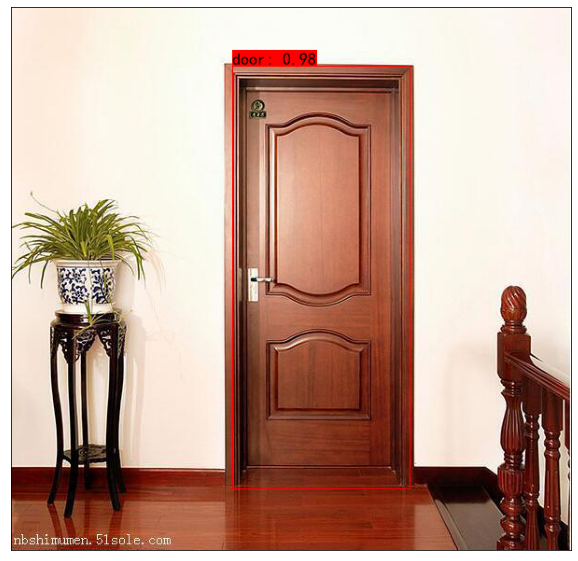

In [12]:
# 测试图片1
detect_image('test/image/door_003.jpg')
print("预测完毕！")

In [ ]:
# 测试图片2
detect_image('test/image/knife_000.jpg')
print("预测完毕！")

In [ ]:
# 测试图片3
detect_image('test/image/phone_007.jpg')
print("预测完毕！")

In [ ]:
# 测试图片4
detect_image('test/image/scissor_001.jpg')
print("预测完毕！")